In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
import torch

In [3]:
data = pd.read_csv("air-quality.csv")

In [4]:
data['Timestamp'] = pd.to_datetime(data['Timestamp'])

data['Hour_sin'] = np.sin(2 * np.pi * data['Hour'] / 24)
data['Hour_cos'] = np.cos(2 * np.pi * data['Hour'] / 24)
data['Day_sin'] = np.sin(2 * np.pi * data['Day'] / 31)
data['Day_cos'] = np.cos(2 * np.pi * data['Day'] / 31)
data['Month_sin'] = np.sin(2 * np.pi * data['Month'] / 12)
data['Month_cos'] = np.cos(2 * np.pi * data['Month'] / 12)

data['Year_sin'] = np.sin(2 * np.pi * data['Year'] / 365)
data['Year_cos'] = np.cos(2 * np.pi * data['Year'] / 365)

In [5]:
data

,Timestamp,Year,Month,Day,Hour,PM2.5,Hour_sin,Hour_cos,Day_sin,Day_cos,Month_sin,Month_cos,Year_sin,Year_cos
0,2017-11-07 12:00:00,2017,11,7,12,64.51,1.224647e-16,-1.000000,0.988468,0.151428,-5.000000e-01,0.866025,-0.162807,-0.986658
1,2017-11-07 13:00:00,2017,11,7,13,69.95,-2.588190e-01,-0.965926,0.988468,0.151428,-5.000000e-01,0.866025,-0.162807,-0.986658
2,2017-11-07 14:00:00,2017,11,7,14,92.79,-5.000000e-01,-0.866025,0.988468,0.151428,-5.000000e-01,0.866025,-0.162807,-0.986658
3,2017-11-07 15:00:00,2017,11,7,15,109.66,-7.071068e-01,-0.707107,0.988468,0.151428,-5.000000e-01,0.866025,-0.162807,-0.986658
4,2017-11-07 16:00:00,2017,11,7,16,116.50,-8.660254e-01,-0.500000,0.988468,0.151428,-5.000000e-01,0.866025,-0.162807,-0.986658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36187,2022-06-04 11:00:00,2022,6,4,11,35.89,2.588190e-01,-0.965926,0.724793,0.688967,1.224647e-16,-1.000000,-0.247022,-0.969010
36188,2022-06-04 12:00:00,2022,6,4,12,33.83,1.224647e-16,-1.000000,0.724793,0.688967,1.224647e-16,-1.000000,-0.247022,-0.969010
36189,2022-06-04 13:00:00,2022,6,4,13,33.05,-2.588190e-01,-0.965926,0.724793,0.688967,1.224647e-16,-1.000000,-0.247022,-0.969010
36190,2022-06-04 14:00:00,2022,6,4,14,35.29,-5.000000e-01,-0.866025,0.724793,0.688967,1.224647e-16,-1.000000,-0.247022,-0.969010


In [6]:
data = data.drop(columns=['Timestamp', 'Year', 'Month', 'Day', 'Hour'])
X = data.drop(columns=['PM2.5']).values
y = data['PM2.5'].values

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#scaler = MinMaxScaler()
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
X_train_scaled
y_train

array([ 41.89,  54.65,  75.87, ...,  46.79, 104.61,  52.97])

In [9]:
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32)

In [10]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

In [11]:
input_size = X_train_tensor.shape[1]
hidden_size = 64
num_layers = 2

In [12]:
model = LSTMModel(input_size, hidden_size, num_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [18]:
losses=[]
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    outputs = model(X_train_tensor.unsqueeze(1))
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    print(f'Epoch , Loss: {loss.item():.4f}')

Epoch , Loss: 1367.1847
Epoch , Loss: 1364.3241
Epoch , Loss: 1361.4746
Epoch , Loss: 1358.6367
Epoch , Loss: 1355.8096
Epoch , Loss: 1352.9938
Epoch , Loss: 1350.1886
Epoch , Loss: 1347.3948
Epoch , Loss: 1344.6117
Epoch , Loss: 1341.8392
Epoch , Loss: 1339.0776
Epoch , Loss: 1336.3265
Epoch , Loss: 1333.5862
Epoch , Loss: 1330.8562
Epoch , Loss: 1328.1366
Epoch , Loss: 1325.4276
Epoch , Loss: 1322.7286
Epoch , Loss: 1320.0400
Epoch , Loss: 1317.3617
Epoch , Loss: 1314.6932
Epoch , Loss: 1312.0348
Epoch , Loss: 1309.3865
Epoch , Loss: 1306.7482
Epoch , Loss: 1304.1196
Epoch , Loss: 1301.5009
Epoch , Loss: 1298.8920
Epoch , Loss: 1296.2927
Epoch , Loss: 1293.7030
Epoch , Loss: 1291.1228
Epoch , Loss: 1288.5524
Epoch , Loss: 1285.9912
Epoch , Loss: 1283.4393
Epoch , Loss: 1280.8971
Epoch , Loss: 1278.3640
Epoch , Loss: 1275.8402
Epoch , Loss: 1273.3256
Epoch , Loss: 1270.8201
Epoch , Loss: 1268.3236
Epoch , Loss: 1265.8361
Epoch , Loss: 1263.3575
Epoch , Loss: 1260.8882
Epoch , Loss: 12

In [19]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor.unsqueeze(1))
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')

Test Loss: 1094.5081


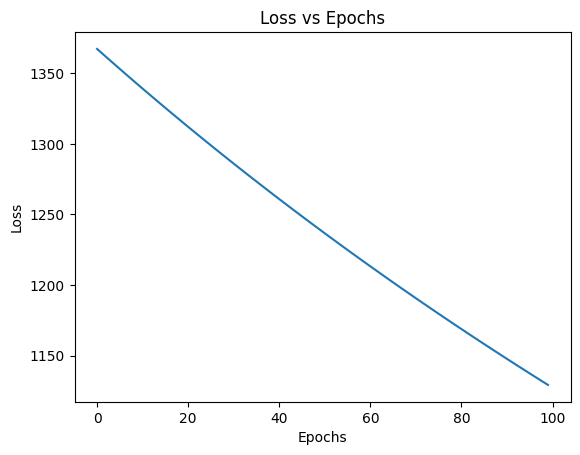

In [20]:
plt.plot(range(num_epochs),losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.show()